In [27]:
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

In [28]:
engine = create_engine("postgresql+psycopg2://voprosovnety@localhost:5432/superstore_db")
with engine.connect() as conn:
    print(conn.execute(text("select 1")).scalar())

1


In [29]:
query = """
select
    f.row_id,
    f.order_id,
    f.order_date,
    f.ship_date,
    c.segment,
    p.category,
    p.sub_category,
    p.product_name,
    g.region,
    g.state,
    g.city,
    f.sales,
    f.profit,
    f.discount,
    f.quantity
from
    fact_sales f
    join dim_customer c on f.customer_id = c.customer_id
    join dim_product p on f.product_key = p.product_key
    join dim_geo g on f.geo_id = g.geo_id
"""

df = pd.read_sql(query, engine, parse_dates=["order_date", "ship_date"])

In [48]:
df["month"] = df["order_date"].dt.to_period("M")
df["discount_bucket"] = pd.cut(
    df["discount"],
    bins=[-0.01, 0, 0.1, 0.2, 1],
    labels=["0%", "0-10%", "10-20%", ">20%"],
    ordered=True
)
df.to_csv("../data/processed/superstore_mart.csv", index=False)

In [31]:
monthly_metrics = (
    df
    .groupby("month")
    .agg(
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum")
    )
    .reset_index()
    .sort_values("month")
)

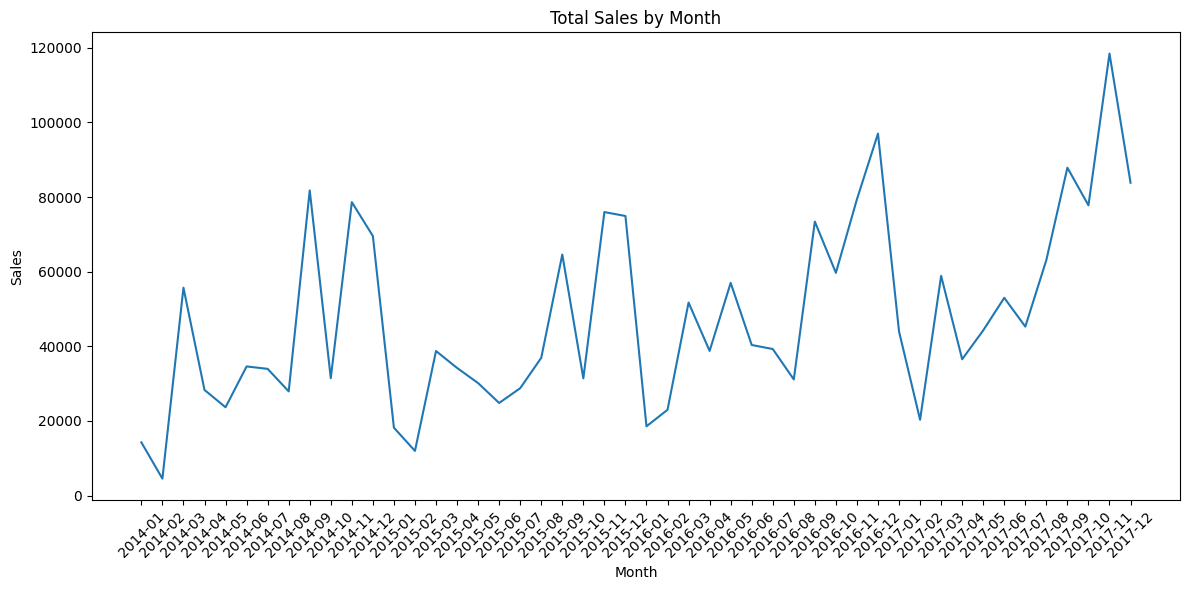

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_metrics["month"].astype(str), monthly_metrics["total_sales"])
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

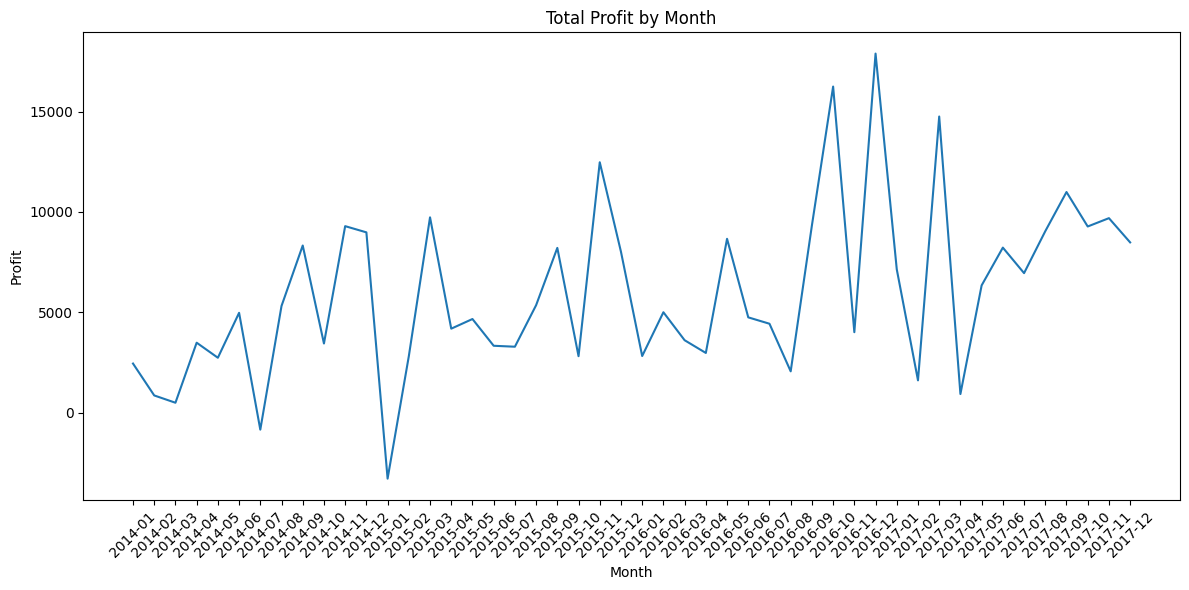

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_metrics["month"].astype(str), monthly_metrics["total_profit"])
plt.title("Total Profit by Month")
plt.xlabel("Month")
plt.ylabel("Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📈 Monthly Sales and Profit Trend

- Total sales show an overall upward trend over time, indicating business growth.
- Profit remains volatile and does not grow proportionally with sales.
- This suggests that increased revenue is partially offset by higher discounts or costs.

In [34]:
segment_metrics = (
    df
    .groupby("segment")
    .agg(
        orders=("order_id", "nunique"),
        rows=("row_id", "size"),
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum"),
        avg_discount=("discount", lambda x: x.mean().round(3))
    )
    .assign(
        profit_margin=lambda x: (x.total_profit / x.total_sales).round(3),
        avg_order_value=lambda x: (x.total_sales / x.orders).round(2)
    )
    .reset_index()
    .sort_values("total_profit", ascending=False)
)

segment_metrics

,segment,orders,rows,total_sales,total_profit,avg_discount,profit_margin,avg_order_value
0,Consumer,2586,5191,1161401.34,134119.33,0.158,0.115,449.11
1,Corporate,1514,3020,706146.44,91979.45,0.158,0.130,466.41
2,Home Office,909,1783,429653.29,60299.01,0.147,0.140,472.67


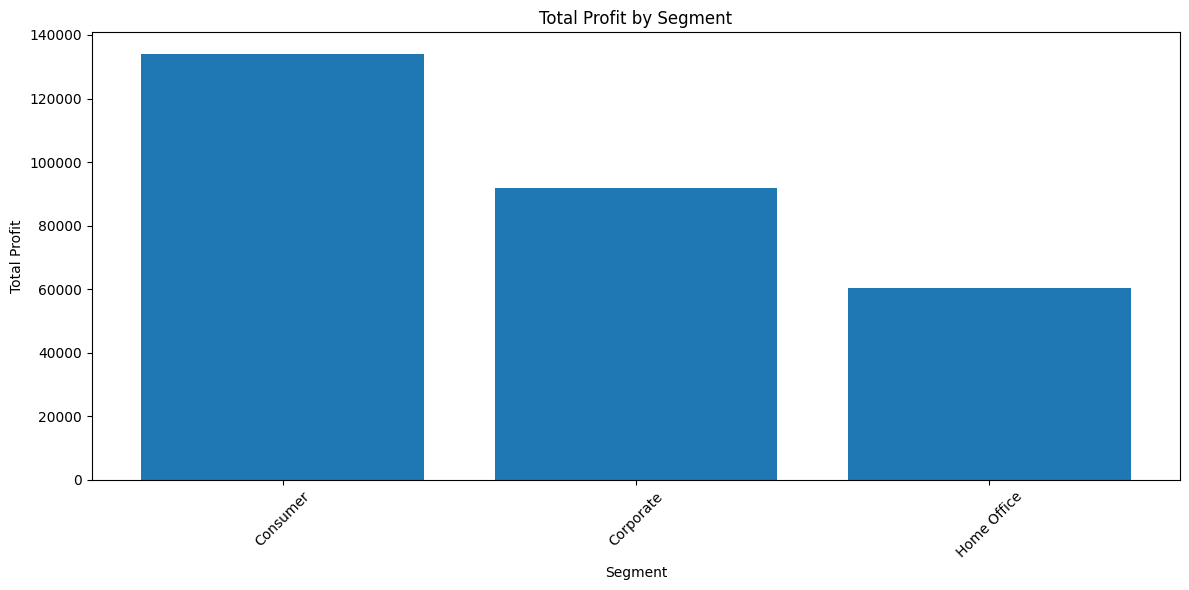

In [35]:
plt.figure(figsize=(12, 6))
plt.bar(segment_metrics["segment"], segment_metrics["total_profit"])
plt.title("Total Profit by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

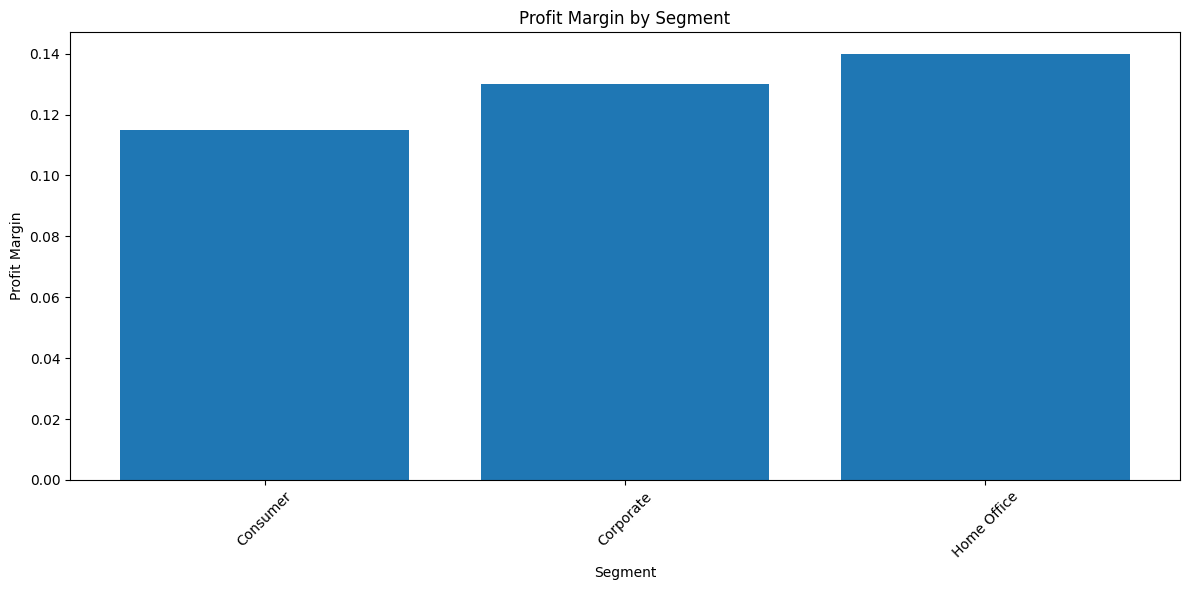

In [36]:
plt.figure(figsize=(12, 6))
plt.bar(segment_metrics["segment"], segment_metrics["profit_margin"])
plt.title("Profit Margin by Segment")
plt.xlabel("Segment")
plt.ylabel("Profit Margin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 👥 Customer Segment Analysis

- The **Consumer** segment generates the highest total profit due to its large sales volume.
- **Home Office** shows the highest profit margin, indicating higher efficiency but lower scale.
- **Corporate** segment performs moderately across both profit and margin.
- This highlights a clear trade-off between revenue scale and profitability efficiency.

In [37]:
category_metrics = (
    df
    .groupby(["category", "sub_category"])
    .agg(
        orders=("order_id", "nunique"),
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum"),
        avg_discount=("discount", lambda x: x.mean().round(3))
    )
    .assign(
        profit_margin=lambda x: (x.total_profit / x.total_sales).round(3)
    )
    .reset_index()
    .sort_values("total_profit", ascending=False)
)

top_subcategories = category_metrics.head()
bottom_subcategories = category_metrics.sort_values("total_profit", ascending=True).head()

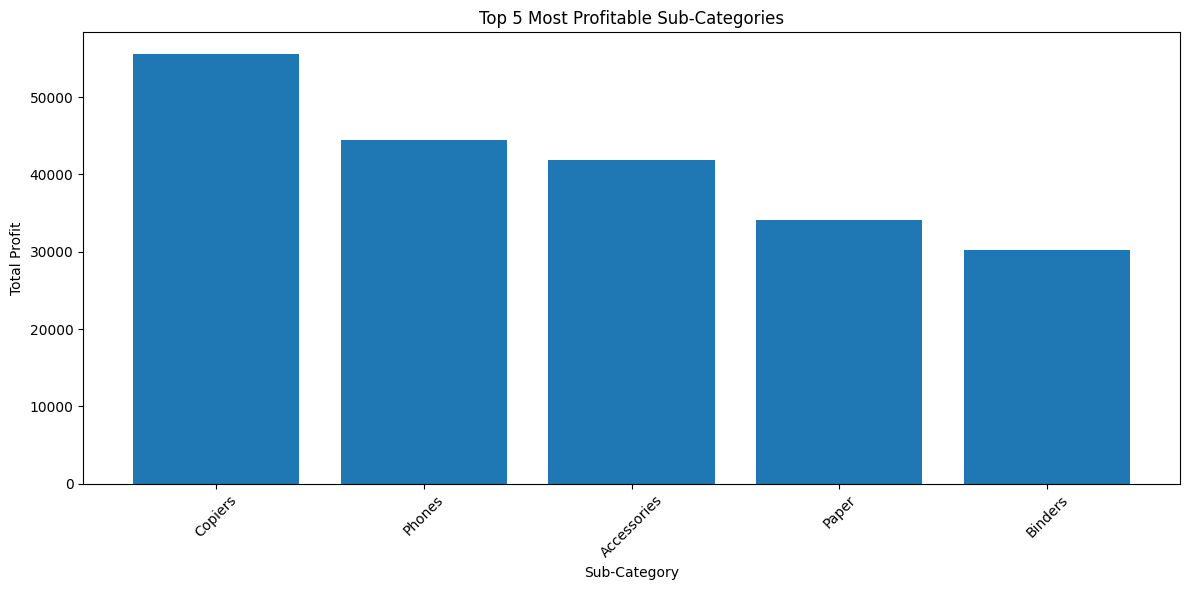

In [38]:
plt.figure(figsize=(12, 6))
plt.bar(top_subcategories["sub_category"], top_subcategories["total_profit"])
plt.title("Top 5 Most Profitable Sub-Categories")
plt.xlabel("Sub-Category")
plt.ylabel("Total Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

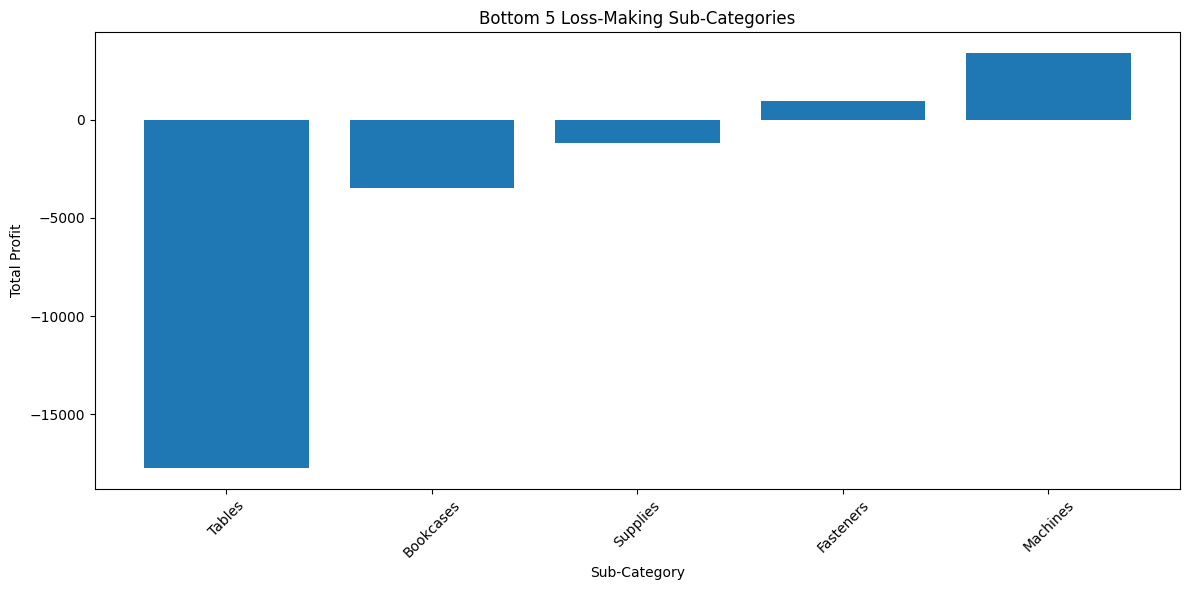

In [39]:
plt.figure(figsize=(12, 6))
plt.bar(bottom_subcategories["sub_category"], bottom_subcategories["total_profit"])
plt.title("Bottom 5 Loss-Making Sub-Categories")
plt.xlabel("Sub-Category")
plt.ylabel("Total Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🗂️ Category & Sub-Category Insights

- **Copiers, Phones, Accessories, Paper, and Binders** are the top profit-generating sub-categories, forming the core profit base of the business.
- **Tables** stand out as a major loss-making sub-category, with losses significantly exceeding all others.
- Other low-performing sub-categories show relatively small losses or near break-even results.
- Business losses are highly concentrated in a single sub-category rather than spread across the product portfolio.

### 💡 Business Recommendations

- Review pricing, discount strategy, and cost structure for **Tables** to identify the root cause of losses.
- Focus growth and marketing efforts on high-profit sub-categories to maximize overall profitability.
- Monitor low-margin categories, but prioritize corrective actions on the most loss-driving products.

In [40]:
discount_metrics = (
    df
    .groupby("discount")
    .agg(
        rows=("row_id", "size"),
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum"),
    )
    .assign(
        profit_margin=lambda x: (x.total_profit / x.total_sales).round(3),
    )
    .reset_index()
    .sort_values("discount")
)

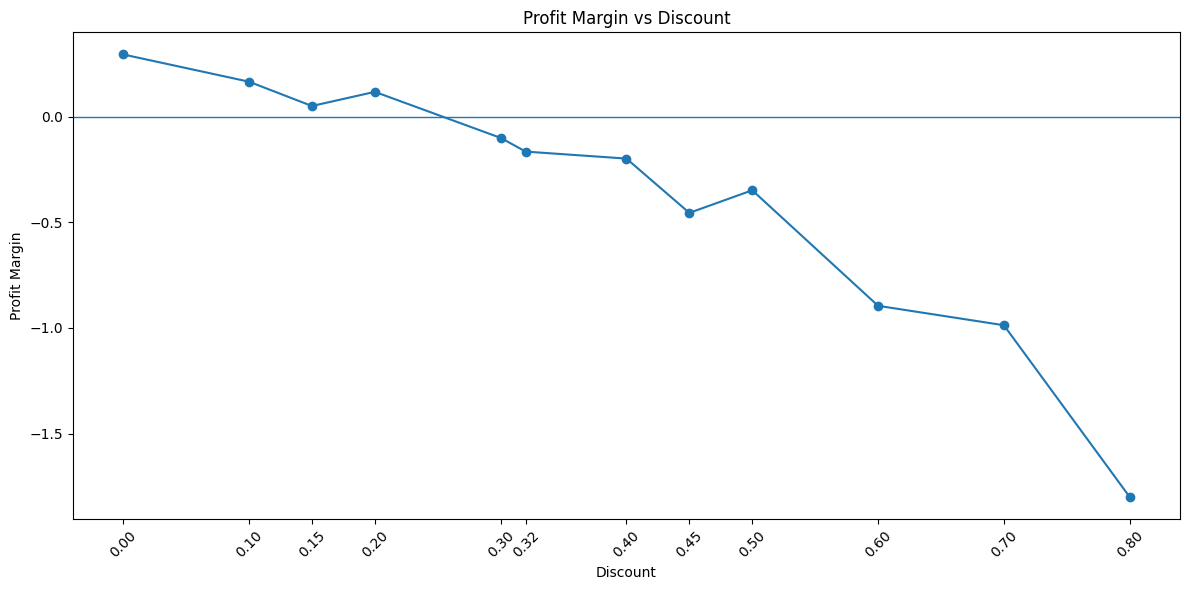

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(discount_metrics["discount"], discount_metrics["profit_margin"], marker="o")
plt.axhline(0, linewidth=1)
plt.title("Profit Margin vs Discount")
plt.xlabel("Discount")
plt.ylabel("Profit Margin")
plt.xticks(discount_metrics["discount"].unique(), rotation=45)
plt.tight_layout()
plt.show()

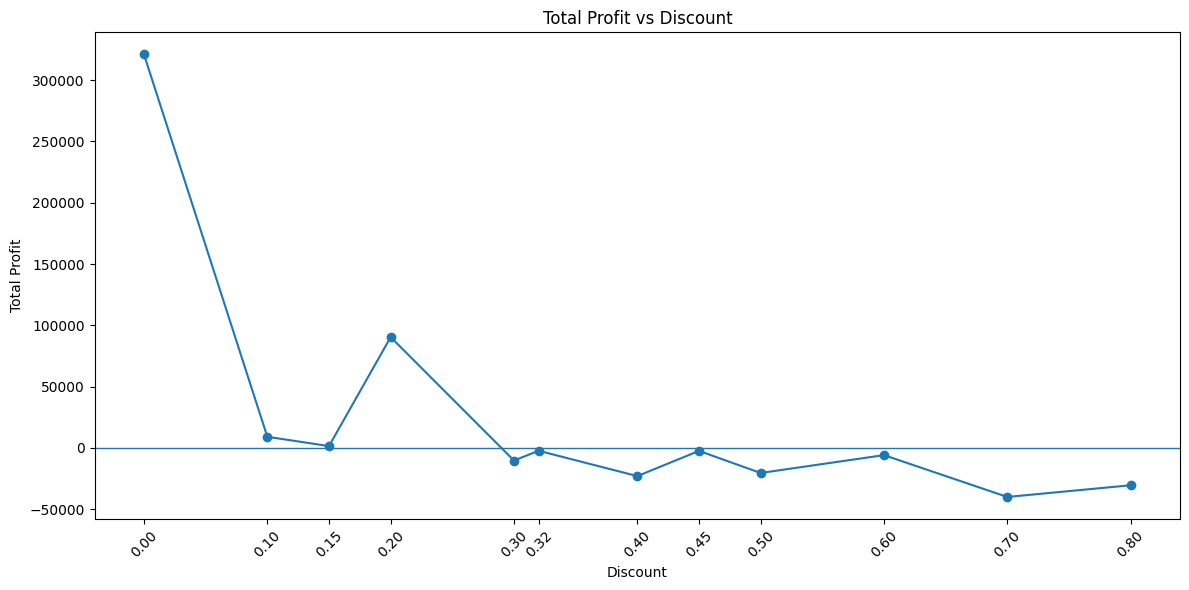

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(discount_metrics["discount"], discount_metrics["total_profit"], marker="o")
plt.axhline(0, linewidth=1)
plt.title("Total Profit vs Discount")
plt.xlabel("Discount")
plt.ylabel("Total Profit")
plt.xticks(discount_metrics["discount"].unique(), rotation=45)
plt.tight_layout()
plt.show()

In [43]:
discount_bucket_metrics = (
    df
    .groupby("discount_bucket", observed=True)
    .agg(
        rows=("row_id", "size"),
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum")
    )
    .assign(
        profit_margin=lambda x: (x.total_profit / x.total_sales).round(3)
    )
    .reset_index()
    .sort_values("discount_bucket")
)

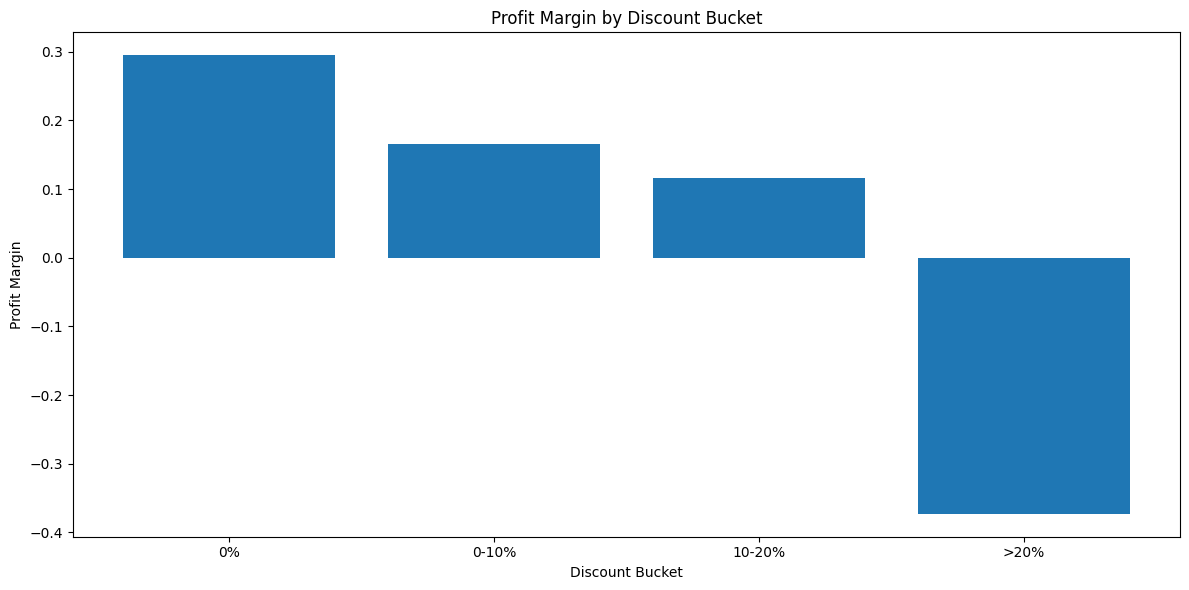

In [44]:
plt.figure(figsize=(12, 6))
plt.bar(discount_bucket_metrics["discount_bucket"], discount_bucket_metrics["profit_margin"])
plt.title("Profit Margin by Discount Bucket")
plt.xlabel("Discount Bucket")
plt.ylabel("Profit Margin")
plt.tight_layout()
plt.show()

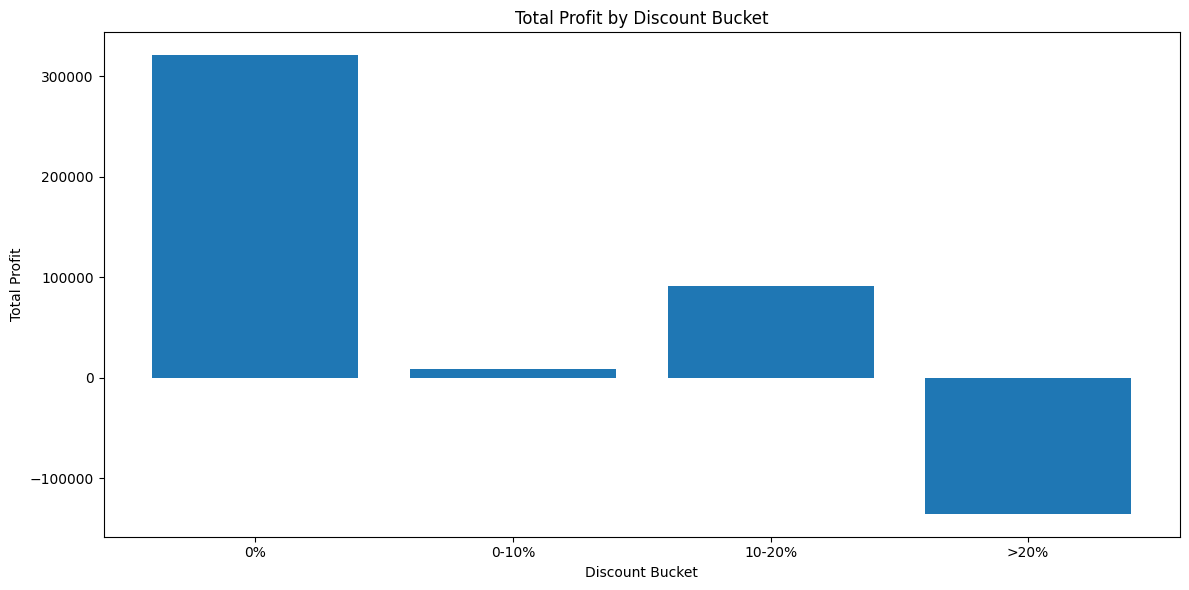

In [45]:
plt.figure(figsize=(12, 6))
plt.bar(discount_bucket_metrics["discount_bucket"], discount_bucket_metrics["total_profit"])
plt.title("Total Profit by Discount Bucket")
plt.xlabel("Discount Bucket")
plt.ylabel("Total Profit")
plt.tight_layout()
plt.show()

### 💸 Discount Impact Analysis

- Profitability declines as discounts increase: the **0%** bucket generates the highest profit and the strongest margins.
- Discounts above **20%** consistently result in **negative total profit**, indicating that aggressive discounting is destroying value.
- The **0–10%** bucket is close to break-even in terms of total profit, suggesting limited upside from small discounts.
- The **10–20%** bucket remains profitable, but with noticeably lower margins than the 0% baseline.

### 💡 Business Recommendations

- Treat **>20%** discounts as an exception case and require approval or guardrails.
- Prioritize pricing / promotion strategies that keep discounts **≤20%**, especially for products with thin margins.
- Combine this analysis with the loss-making sub-categories (e.g., *Tables*) to identify where discounting is most harmful.

In [46]:
df_hi = df[df["discount_bucket"] == ">20%"]

high_discount_losses = (
    df_hi
    .groupby(["category", "sub_category"], observed=True)
    .agg(
        rows=("row_id", "size"),
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum")
    )
    .assign(
        profit_margin=lambda x: (x.total_profit / x.total_sales).round(3)
    )
    .reset_index()
    .sort_values("total_profit")
    .head(10)
)

high_discount_losses

,category,sub_category,rows,total_sales,total_profit,profit_margin
5,Office Supplies,Binders,613,36140.70,-38510.64,-1.066
3,Furniture,Tables,176,89956.68,-30698.28,-0.341
7,Technology,Machines,53,76839.15,-29555.40,-0.385
0,Furniture,Bookcases,70,28543.98,-11097.79,-0.389
4,Office Supplies,Appliances,67,3382.48,-8629.67,-2.551
1,Furniture,Chairs,158,70005.55,-6737.19,-0.096
8,Technology,Phones,109,34337.39,-6385.83,-0.186
2,Furniture,Furnishings,138,6644.68,-5944.64,-0.895
6,Technology,Copiers,9,16919.82,2183.00,0.129


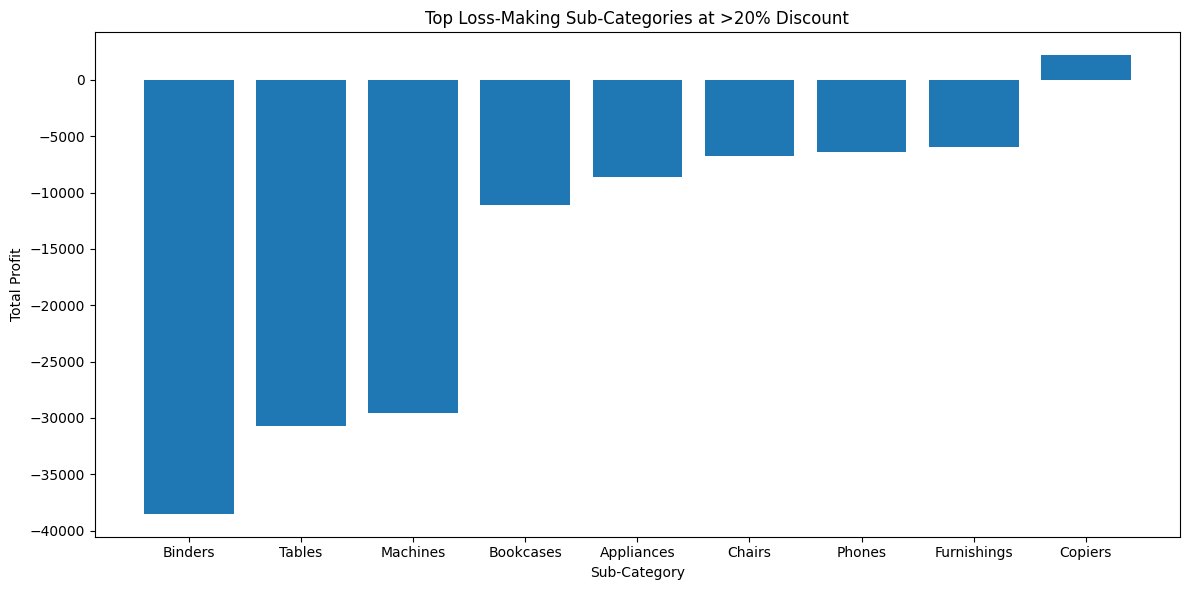

In [47]:
plt.figure(figsize=(12, 6))
plt.bar(high_discount_losses["sub_category"], high_discount_losses["total_profit"])
plt.title("Top Loss-Making Sub-Categories at >20% Discount")
plt.xlabel("Sub-Category")
plt.ylabel("Total Profit")
plt.tight_layout()
plt.show()

### 🧨 High-Discount Loss Drivers (>20%)

- Under **>20%** discounts, losses are concentrated in a few sub-categories rather than being evenly distributed across the catalog.
- **Binders** is the largest loss driver at high discounts, followed by **Tables** and **Machines**, indicating that aggressive discounting is particularly harmful for these product groups.
- This suggests that blanket discount campaigns can destroy value unless discount limits are tailored by product type.

### 💡 Business Recommendations

- Introduce product-level discount guardrails: restrict **>20%** discounts for **Binders**, **Tables**, and **Machines** unless a specific clearance strategy is justified.
- Review unit economics for these sub-categories (costs, shipping, returns) and evaluate whether price increases or assortment changes are needed.
- Combine this view with sales volume to prioritize actions on categories that are both high-volume and loss-making at high discounts.

## ✅ Key Takeaways

- Sales grow over time, but profit does not scale proportionally, highlighting the importance of margin control.
- Consumer customers drive the largest share of absolute profit, while Home Office shows higher efficiency (profit margin).
- Profit is concentrated in a handful of sub-categories (e.g., Copiers, Phones), while losses are heavily concentrated in a small number of products.
- Discounts materially reduce profitability: **>20%** discounts lead to negative total profit overall.
- At high discounts (>20%), losses are driven by specific sub-categories (notably Binders, Tables, and Machines), suggesting the need for product-level discount guardrails.